In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
#sys.path.append('../Yirui_all_SFH')
from pySEDM.codeunits import *
from pySEDM.all_func import readsnap, get_center
%matplotlib inline
import seaborn as sns
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

In [4]:
def cal_Z(metal):
    
    if len(metal.shape)==1:  #only 1 particle, transfer to 2-dimension form
        metal=np.asarray([metal])
        
    #total masses of the 12 elements ie the masses of the particles
    mass=np.sum(metal, axis=1)    
    Z=(mass - metal[:,0] - metal[:,6])/mass #metal[:,0]: He , metal[:,6]: H 
    
    if len(Z) == 1:
        Z=Z[0]
    return Z

# read all info

In [5]:
#fileseq = '2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP'
#dir_in='/home/yz69/SEDMORPH/SimnsGadget3/data/major/'+fileseq+'/'
dir_in = ''
snap = 119

# only_right = True # on use particles in 1 galaxy, only select the particles on the right
only_right = False # false for the mergered galaxy

### key line

In [6]:
str_snap = str(snap).zfill(3)
filename = 'snap_'+str_snap + '.hdf5'
# key line
snap_data=readsnap(filename, dir_in, get_stars=True, get_gas=True)

/Users/hinleung/OneDrive - University of St Andrews/Documents/St Andrews stuff/PhD project/PSB_MaNGA/Yirui_test_cube/simulation_info/pySEDM/readsnap.py:127: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  GasCoordinates =  f['PartType0/Coordinates'].value
/Users/hinleung/OneDrive - University of St Andrews/Documents/St Andrews stuff/PhD project/PSB_MaNGA/Yirui_test_cube/simulation_info/pySEDM/readsnap.py:128: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  GasVelocity =  f['PartType0/Velocities'].value
/Users/hinleung/OneDrive - University of St Andrews/Documents/St Andrews stuff/PhD project/PSB_MaNGA/Yirui_test_cube/simulation_info/pySEDM/readsnap.py:129: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  GasIDs =  f['PartType0/ParticleIDs'].value
/Users/hinleung/OneDrive - University of St Andrews/Documents/St Andrews stuff/PhD project/PSB_MaNGA/Yirui_test_cube/simulation_in

In [7]:
stars=snap_data['stars']
if only_right:
    idx = np.bool_(stars['x'] > 0)
    for keys in stars.keys():
        stars[keys] = stars[keys][idx]

In [8]:
gas=snap_data['gas']
if only_right:
    idx = np.bool_(gas['x'] > 0)
    for keys in gas.keys():
        gas[keys] = gas[keys][idx]

In [9]:
snap_data.keys()

dict_keys(['snap_time', 'gas', 'stars'])

In [10]:
print(snap_data['snap_time'])

13.079954777963868


# trying to plot age vs metallicity plot

In [11]:
# read in the true SFH
age_at_z = cosmo.age(0).value
sim_data = np.loadtxt('../snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
model_sfh = sim_data[:,2]
model_ages = sim_data[:,0]
mask = model_ages > 0
model_ages = model_ages[mask].copy()
model_sfh = model_sfh[mask].copy()

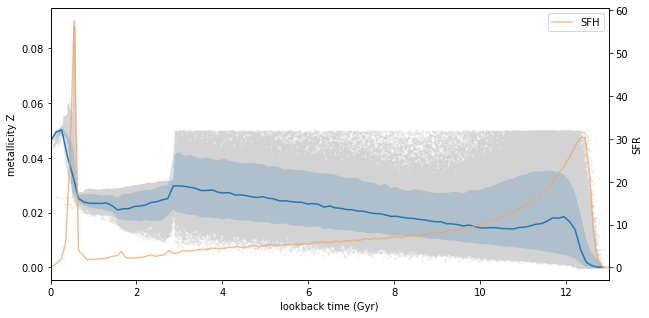

0.021025183


In [22]:
star_ages = stars['age']
star_Z = cal_Z(stars['metal'])
age_bins = np.linspace(0, max(star_ages), 101)
bin_ind = np.digitize(star_ages, age_bins)
binned_Z = []
Z_percentiles = []
for i in range(1, len(age_bins)):
    binned_Z.append(star_Z[bin_ind==i])
    Z_percentiles.append(np.percentile(star_Z[bin_ind==i], (16,50,84)))
Z_percentiles = np.array(Z_percentiles).T

fig, ax1 = plt.subplots(figsize=[10,5])
ax1.scatter(stars['age'], cal_Z(stars['metal']), color='lightgray', s=1, alpha=0.1, zorder=-1)
ax1.plot(age_bins[:-1], Z_percentiles[1])
ax1.fill_between(age_bins[:-1], Z_percentiles[0], Z_percentiles[2], alpha=0.2)
ax1.set_xlim([0, max(star_ages)])
ax1.set_xlabel('lookback time (Gyr)')
ax1.set_ylabel('metallicity Z')

#add SFH on the right y axis
ax2 = ax1.twinx()
ax2.plot(model_ages, model_sfh, color='sandybrown', label='SFH', alpha=0.7)
ax2.legend()
ax2.set_ylabel('SFR')

plt.show()

print(np.mean(star_Z))

Conclusion: applying the break of the 2-step metallicity at tburst should be appropiate

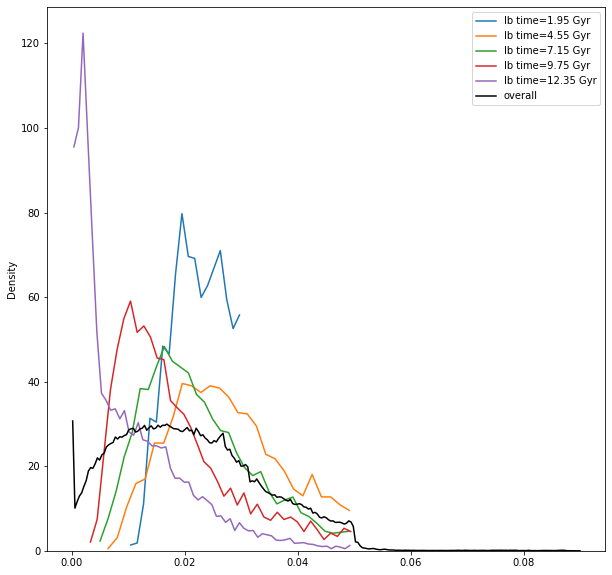

In [26]:
# how does metallicity spread within each bin
fig, ax = plt.subplots(figsize=[10,10])
offset = np.array([])
for i in range(len(binned_Z)):
    this_offset = binned_Z[i]
    offset = np.concatenate([offset, this_offset])
    if (i+5)%20 == 0:
        sns.histplot(this_offset, label='lb time='+str(np.round(age_bins[i],2))+' Gyr', ax=ax, element="poly", fill=False, stat="density")
sns.histplot(offset, ax=ax, label='overall', element="poly", fill=False, stat="density", color='black')
ax.legend()
#ax.set_yscale('log')
plt.show()

In [50]:
10**0.30

1.9952623149688795

# age

In [14]:
stars.keys()

dict_keys(['x', 'y', 'z', 'vx', 'vy', 'vz', 'id', 'metal', 'mass', 'age'])

In [15]:
stars['age']

array([12.660849 ,  7.7399983, 10.942089 , ..., 12.631454 , 12.626441 ,
       12.731385 ], dtype=float32)

Text(0.5, 1.0, 'dashed line --> when the simulation starts')

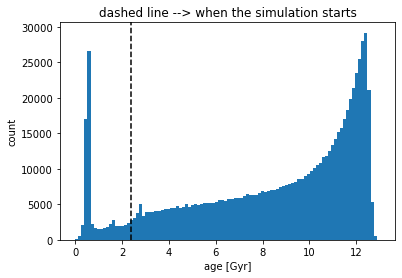

In [16]:
plt.hist(stars['age'], bins=np.linspace(0, 13, 101))
plt.xlabel("age [Gyr]")
plt.ylabel("count")

sim_start_time = snap_data['snap_time'] - 10.7
plt.axvline(sim_start_time, ls='--', c='k')
plt.title("dashed line --> when the simulation starts")

# metallicity 

Text(0.5,1,'dashed line --> Z_sun = 0.02')

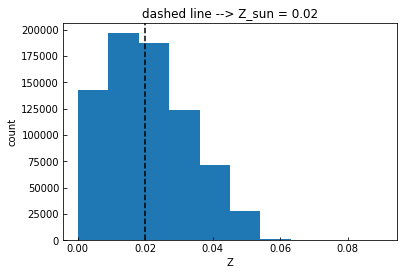

In [12]:
Z_list = cal_Z(stars['metal'])
plt.hist(Z_list)
plt.xlabel("Z")
plt.ylabel("count")

plt.axvline(0.02, ls='--', c='k')
plt.title("dashed line --> Z_sun = 0.02")

In [13]:
#O/H ratio, 12+log(O/H)
O_H_gas = 12 + np.log10(gas['metal'][:,3]/gas['metal'][:,6])
O_H_star = 12 + np.log10(stars['metal'][:,3]/stars['metal'][:,6])
O_H = np.append(O_H_gas, O_H_star)
len(O_H)

799901

In [14]:
get_center(fileseq, snap)

array([-1.60671, -4.53487, -6.35084, -1.60671, -4.53487, -6.35084])

In [15]:
xc, yc, zc =get_center(fileseq, snap)[:3]
xlist = gas['x']
ylist = gas['y']
zlist = gas['z']
rlist_gas = np.sqrt( (xlist-xc)**2 + (ylist-yc)**2 +(zlist-zc)**2 )
xlist = stars['x']
ylist = stars['y']
zlist = stars['z']
rlist_star = np.sqrt( (xlist-xc)**2 + (ylist-yc)**2 +(zlist-zc)**2 )
rlist = np.append(rlist_gas, rlist_star)

len(rlist)

799901

In [16]:
mass=np.append(gas['mass'],stars['mass'])
rbins=np.linspace(0, 30,13)
rbins=np.linspace(0, 5,11)
radial_O_H = np.zeros(len(rbins)-1)
for i in range(len(rbins)-1):
    idx = ((rlist > rbins[i]) & (rlist < rbins[i+1]))
#     print idx.sum()
#     print np.where(idx>0)
    if idx.sum() >0:
        radial_O_H[i]= np.average(O_H[idx], weights=mass[idx])
#         radial_O_H[i]= np.average(O_H[idx])#, weights=mass[idx])        

In [17]:
rmid = (rbins[1:]+rbins[:-1])/2.0

In [18]:
k,b=np.polyfit(rmid, radial_O_H,1)
print b
print "Gradient: %5.9f dex/kpc" %k
print "0.0585 dex/kpc for the Milky Way"

10.3318461823
Gradient: -0.062927720 dex/kpc
0.0585 dex/kpc for the Milky Way


Text(0,0.5,'12+log(O/H) [dex]')

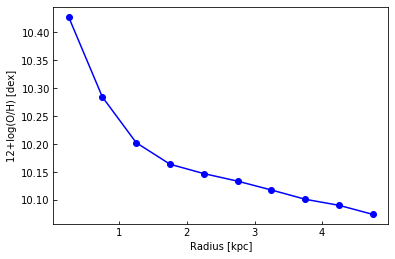

In [19]:
plt.plot(rmid,radial_O_H, 'b-o')
# plt.plot([0,rbins[-1]], [b, k*rbins[-1]+b], 'k--', lw=1, )
# plt.text(16, 10, "Gradient: %5.4f dex/kpc" %k)
plt.xlabel('Radius [kpc]')
plt.ylabel('12+log(O/H) [dex]')